In [1]:
# Install dependencies.
!mkdir /root/.ssh
!mv /content/id_rsa /root/.ssh/id_rsa
!chmod 600 /root/.ssh/id_rsa
!ssh-keyscan github.com >> ~/.ssh/known_hosts
!git clone git@github.com:TimothyAlexisVass/udi.git
!rm -r sample_data
!pip install -qq --upgrade transformers accelerate git+https://github.com/TimothyAlexisVass/diffusers.git

!mv udi/worker/bilateral_filter.py /content
!rm -r sample_data

# github.com:22 SSH-2.0-babeld-dd067d10
# github.com:22 SSH-2.0-babeld-dd067d10
# github.com:22 SSH-2.0-babeld-dd067d10
# github.com:22 SSH-2.0-babeld-dd067d10
# github.com:22 SSH-2.0-babeld-dd067d10
Cloning into 'udi'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 401 (delta 37), reused 69 (delta 26), pack-reused 307
Receiving objects: 100% (401/401), 62.23 KiB | 513.00 KiB/s, done.
Resolving deltas: 100% (182/182), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 66.7 MB/s eta 0:00:00
     ━━━━

In [3]:
# Set the details for your model here:
import torch

from diffusers import StableDiffusionXLPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
base = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
)

_ = base.to("cuda")

tokenizer = base.tokenizer            # cpu
tokenizer_2 = base.tokenizer_2        # cpu
scheduler = base.scheduler            # cpu
text_encoder = base.text_encoder      # cuda
text_encoder_2 = base.text_encoder_2  # cuda
unet = base.unet                      # cuda

torch.cuda.empty_cache()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
print(unet.parameters().__next__().device)
print(scheduler.sigmas)
torch.cuda.empty_cache()
!nvidia-smi

cuda:0
tensor([14.6146, 14.5263, 14.4386,  ...,  0.0413,  0.0292,  0.0000])
Fri Oct 20 17:33:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |   7045MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
            

  0%|          | 0/20 [00:00<?, ?it/s]

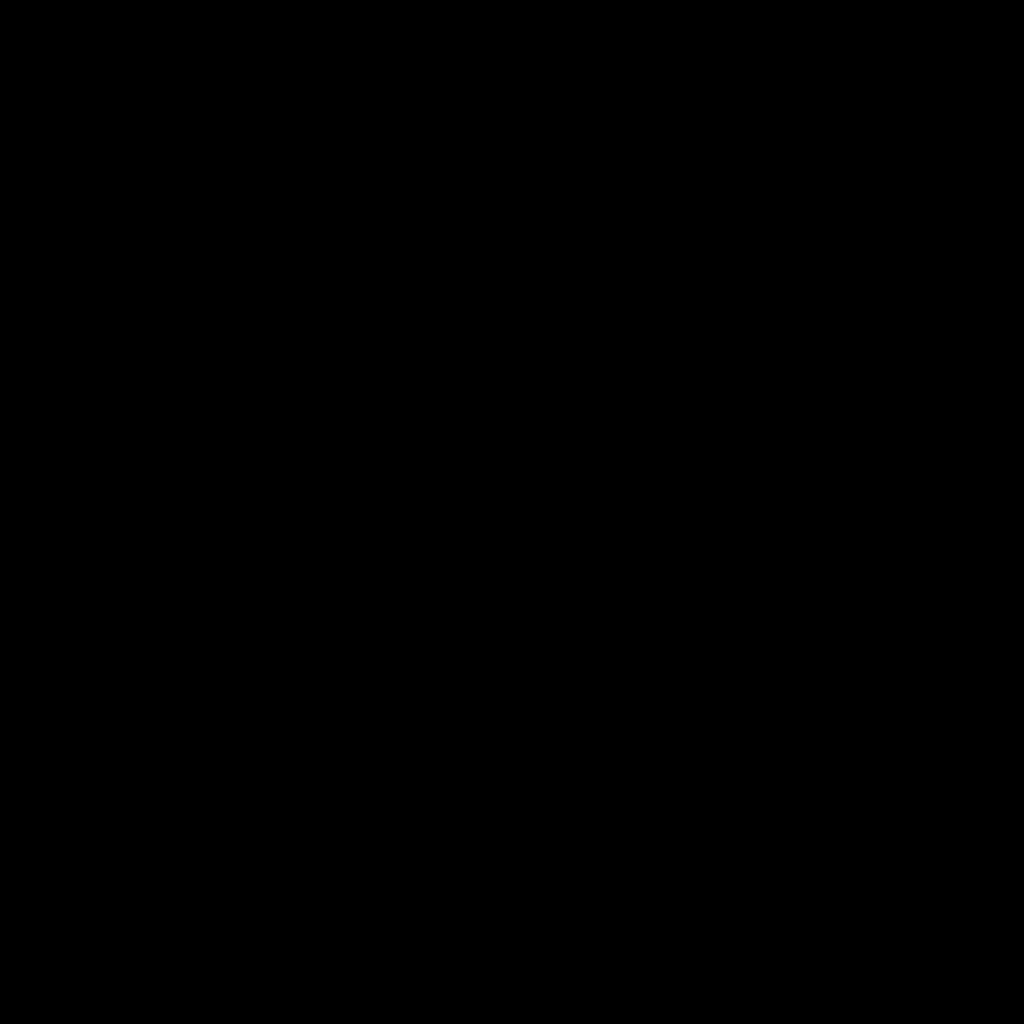

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [38]:
base = diffusers.StableDiffusionXLPipeline(**base.components)
# @title Default title text
import os
import zipfile
import random
import torch
import diffusers
from bilateral_filter import adaptive_bilateral_filter
prompt = f"Steampunk photo of antropomorphic (suricata), pixar, cute, in gray mecha armor looking happy, daylight lush nature park background. Intricate details even to the smallest particle, extreme detail of the enviroment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k"
negative_prompt = "bokeh, blur, helmet, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands"
num_inference_steps = 20

def filter(latents, timestep, sharpness=2):
    t = 1.0 - (timestep / 999.0) # You may adjust this based on your needs

    # Perform sharpness operation on the latents
    alpha = 0.001 * sharpness * t
    degraded_latents = adaptive_bilateral_filter(latents)
    sharp_latents = degraded_latents * alpha + latents * (1.0 - alpha)

    return sharp_latents

sharpness = None

def callback(s, t, l):
  if sharpness != 0:
    latents = filter(l, t, sharpness)
  else:
    latents = l
  return {"latents": latents}

parameters = {
    "prompt": prompt,
    "negative_prompt": negative_prompt,
    "num_inference_steps": num_inference_steps,
    "output_type": "latent",
    "num_images_per_prompt": 1,
    "guidance_scale": 8,
    # "denoising_start": 0,
    # "denoising_end": round(step_fraction, 4),
    "callback": callback
}

height = 1024
width = 1024
# latents = torch.randn((parameters["num_images_per_prompt"], base.unet.config.in_channels, height // 8, width // 8), generator=parameters["generator"]).to("cuda") * base.scheduler.init_noise_sigma

# latents = base.prepare_latents(parameters["num_images_per_prompt"], unet.config.in_channels, height, width, None, base.device, parameters["generator"])

def normalize_tensor(tensor):
  min_val = torch.min(tensor)
  return (tensor - min_val) / (torch.max(tensor) - min_val)

@torch.no_grad()
def decode_latents(latents, saturation=50, contrast=50, brightness=50, normalize=False):
    scaling = 4.444 + saturation / 16

    samples = vae.decode(latents * scaling).sample
    if normalize:
        samples = normalize_tensor(samples)
    else:
        samples = samples.mul(contrast/100).add(brightness/100).clamp(0, 1)
    return base.numpy_to_pil(samples.permute(0, 2, 3, 1).cpu().numpy())

for sharpness in range(-10, 12, 2):
  wow = base(**parameters, generator=torch.manual_seed(2222)).images
  image = decode_latents(wow, normalize=True)[0]
  display(image)
  image.save(parameters["prompt"][:20]+str(sharpness)+".png")

In [ ]:
import torch

# Sample tensor
tensor = torch.tensor([1.1, 1.0, 0.9, 0.8, -0.2])

# Find the minimum and maximum values in the tensor
min_val = torch.min(tensor)
max_val = torch.max(tensor)

# Perform linear normalization
normalized_tensor = (tensor - min_val) / (max_val - min_val)

print(normalized_tensor)

In [ ]:
# @title Default title text
import diffusers

def model(pipeline, model_type):
        if hasattr(diffusers, pipeline):
            model_class = getattr(diffusers, pipeline)
            return model_class(**base.components)
        else:
            raise ValueError(f"Pipeline '{pipeline}' does not exist in Diffusers")
@torch.no_grad()
def decode_latents(latents, saturation=50, contrast=50, brightness=50):
    scaling = 5 + saturation / 16
    print("scaling", scaling)
    samples = vae.decode(latents * scaling).sample
    samples = samples.mul(contrast/100).add(brightness/100).clamp(0, 1).cpu()
    return base.numpy_to_pil(samples.permute(0, 2, 3, 1).numpy())

def run_inference(pipeline, model_type, instructions):
    global num_inference_steps
    num_inference_steps = instructions['num_inference_steps'] = instructions.get('num_inference_steps', 20)

    seed = random.randint(1, 2147483647) if instructions.get('seed', 0) == 0 else instructions['seed']
    saturation = instructions.get('saturation', 50)
    brightness = instructions.get('brightness', 50)
    contrast = instructions.get('contrast', 50)

    parameters = {
        key: instructions[key]
        for key in instructions
        if key not in [
            'seed',
            'saturation',
            'brightness',
            'contrast'
        ]
    }

    parameters['generator'] = torch.manual_seed(seed)
    parameters['output_type'] = 'latent'

    pipe = model(pipeline, model_type).to('cuda')

    latents = pipe(**parameters).images

    images = decode_latents(latents, saturation, contrast, brightness)

    for index, image in enumerate(images):
        display(image)

    pipe = None
    torch.cuda.empty_cache()

instructions = {
    "prompt": f"Steampunk photo of antropomorphic (suricata), pixar, cute, in (gray) mecha armor looking happy, daylight lush nature park background. intricate details even to the smallest particle, extreme detail of the enviroment, sharp portrait, well lit, interesting outfit, beautiful shadows, bright, photoquality, ultra realistic, masterpiece, 8k",
    "seed": 2222,
    "negative_prompt": "helmet, ugly, old, boring, photoshopped, tired, wrinkles, scar, gray hair, big forehead, crosseyed, dumb, stupid, cockeyed, disfigured, blurry, assymetrical, unrealistic, grayscale, black and white, bald, high hairline, balding, receeding hairline, grayscale, bad anatomy, unnatural irises, no pupils, blurry eyes, dark eyes, extra limbs, deformed, disfigured eyes, out of frame, no irises, assymetrical face, broken fingers, extra fingers, disfigured hands",
    "guidance_scale": 9
}

run_inference("StableDiffusionXLPipeline", "base", instructions)

In [34]:
!zip -r png_files.zip *.png
!rm -r *.png

updating: Steampunk photo of a0.png (deflated 0%)
updating: Steampunk photo of a-10.png (deflated 0%)
updating: Steampunk photo of a10.png (deflated 0%)
updating: Steampunk photo of a-2.png (deflated 0%)
updating: Steampunk photo of a2.png (deflated 0%)
updating: Steampunk photo of a-4.png (deflated 0%)
updating: Steampunk photo of a4.png (deflated 0%)
updating: Steampunk photo of a-6.png (deflated 0%)
updating: Steampunk photo of a6.png (deflated 0%)
updating: Steampunk photo of a-8.png (deflated 0%)
updating: Steampunk photo of a8.png (deflated 0%)
